In [1]:
import sys
sys.path.append('../code')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from sklearn.model_selection import ShuffleSplit
from sklearn.decomposition import PCA
import pickle

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
# device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

import contrastive_functions

In [2]:
neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'
noise_fold = 0
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

In [3]:
noise_fold = 0
data_dict = contrastive_functions.get_marker_decode_dataframes(noise_fold = noise_fold)
wrist_df = data_dict['wrist_df']
task_neural_df = data_dict['task_neural_df']
notask_neural_df = data_dict['notask_neural_df']
metadata = data_dict['metadata']
cv_dict = data_dict['cv_dict']

neuron_list = notask_neural_df['unit'].unique()

neural_offset = 10 # try 50-150 ms offset
window_size = 70
label_col = 'layout'

data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays
training_generator, training_eval_generator, validation_generator, testing_generator = generators

X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

test_labels = testing_set[:][2].detach().cpu().numpy()

unit_corr_array = list()
for unit_idx in range(X_train_data.shape[1]):
    unit_corr = list()
    for mrk_idx in range(y_test_data.shape[1]):
        unit_corr.append(np.abs(np.corrcoef(X_train_data[:, unit_idx], y_train_data[:, mrk_idx])[0,1]))
    unit_corr_array.append(np.array(unit_corr))

unit_corr_array = np.vstack(unit_corr_array)

sort_indices = np.argsort(np.mean(unit_corr_array, axis=1))
sorted_neuron_list = neuron_list[sort_indices]

# func_dict = {'wiener': contrastive_functions.run_wiener}
func_dict = {'wiener': contrastive_functions.run_wiener, 'rnn': contrastive_functions.run_rnn}
# fpath = '../data/SPK20220308/neuron_num_results/'

num_neurons = 20

neuron_subset = sorted_neuron_list
# neuron_subset = sorted_neuron_list[:num_neurons]

# Filter neural_df with task info to random subset of neurons
task_unit_mask = np.in1d(task_neural_df['unit'].values, neuron_subset)
layout_mask = task_neural_df['unit'].str.contains(pat='layout')

task_neural_df_filtered = task_neural_df[np.logical_or.reduce([task_unit_mask, layout_mask])].reset_index(drop=True)

# Filter neural_df without task info to random subset of neurons
notask_unit_mask = np.in1d(notask_neural_df['unit'].values, neuron_subset)
notask_neural_df_filtered = notask_neural_df[np.logical_or.reduce([notask_unit_mask])].reset_index(drop=True)

df_dict = {'task': {'df': task_neural_df_filtered, 'task_info': True, 'num_cat': 4}, # num_cat = number of categorical features
            'notask': {'df': notask_neural_df_filtered, 'task_info': False, 'num_cat': 0}}


decode_results = dict()
model_dict = dict()
for func_name, func in func_dict.items():
    decode_results[func_name] = dict()
    model_dict[func_name] = dict()
    for df_type, pred_df in df_dict.items():
        print(f'{func_name}_{df_type} num_neurons: {num_neurons}')
        model, res_dict = func(wrist_df, pred_df['df'], neural_offset, cv_dict, metadata, task_info=pred_df['task_info'],
                                window_size=window_size, num_cat=pred_df['num_cat'], label_col=label_col)

        decode_results[func_name][df_type] = res_dict
        model_dict[func_name][df_type] = model


/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neural_temp_df['rates'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wrist_temp_df['posData'][unit_mask] = noise_data
/home/nick/Donoghue_lab/ncm_2023/notebooks/../code/contrastive_functions.py:332: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

wiener_task num_neurons: 20
wiener_notask num_neurons: 20
rnn_task num_neurons: 20
**********
Epoch: 10/1000 ... Train Loss: 0.8041  ... Validation Loss: 0.8904
**********
Epoch: 20/1000 ... Train Loss: 0.7071  ... Validation Loss: 0.8265
****.*....
Epoch: 30/1000 ... Train Loss: 0.6682  ... Validation Loss: 0.8347
.. Early Stop; Min Epoch: 26
rnn_notask num_neurons: 20
**********
Epoch: 10/1000 ... Train Loss: 0.0706  ... Validation Loss: 0.1756
**********
Epoch: 20/1000 ... Train Loss: 0.0154  ... Validation Loss: 0.1397
.*.*......
Epoch: 30/1000 ... Train Loss: 0.0092  ... Validation Loss: 0.1393
 Early Stop; Min Epoch: 24


In [8]:
num_cat = 4
exclude_processing = np.zeros(len(task_neural_df_filtered['unit'].unique()))
exclude_processing[-num_cat:] = np.ones(num_cat)
exclude_processing = exclude_processing.astype(bool)

data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, task_neural_df_filtered, neural_offset, cv_dict, metadata, exclude_neural=exclude_processing,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays

In [22]:
plot_trials = range(0,3000)
batch_labels = training_set.batch_labels[plot_trials]
batch_trial = training_set.batch_trials[plot_trials]
output, hidden, cell = model_dict['rnn']['task'](training_set[plot_trials][0].float().to(device))
hidden = torch.concat(hidden, dim=2).detach().cpu().numpy()
num_trials, trial_length, num_hidden = hidden.shape

# hidden = hidden.reshape(-1, num_hidden)
hidden = hidden[:,-1,:]

n_components = 10
hidden_pca = PCA(n_components=n_components)
hidden_transformed = hidden_pca.fit_transform(hidden)
# hidden_transformed = hidden_transformed.reshape(num_trials, trial_length, n_components)


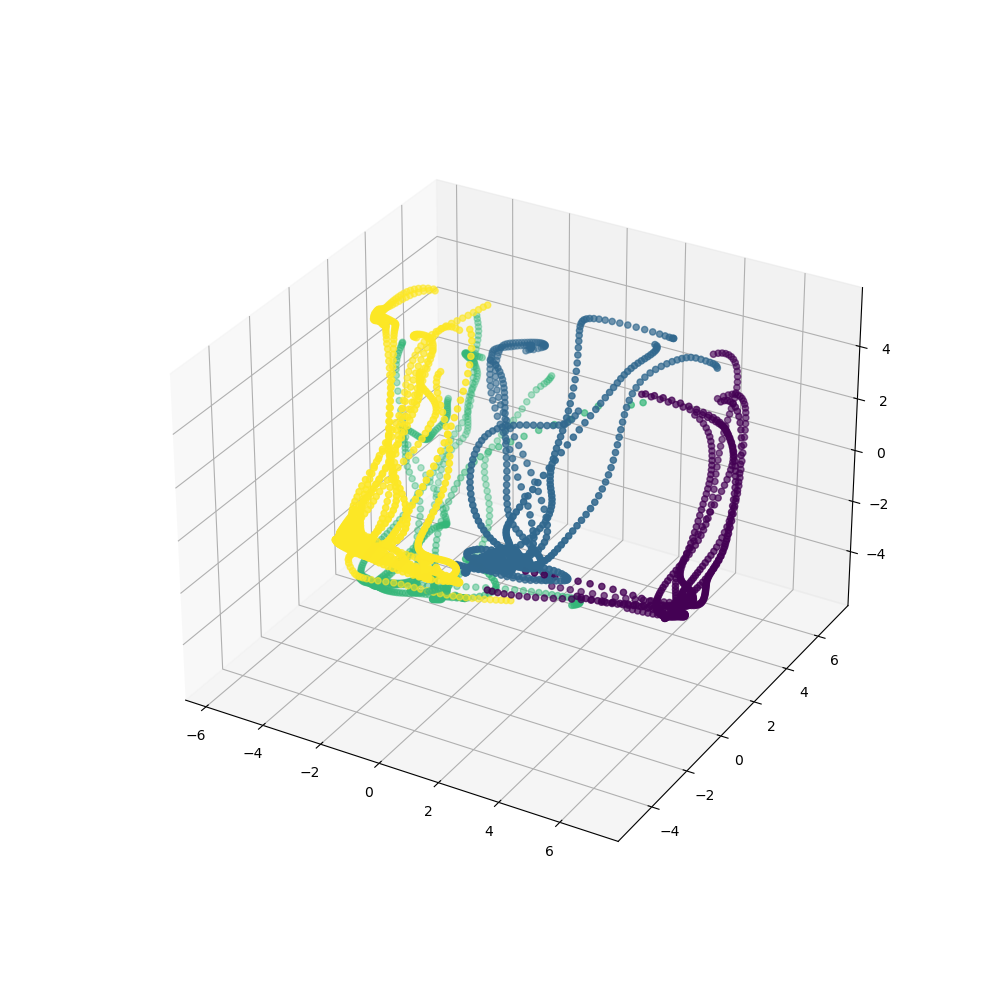

In [23]:
%matplotlib widget
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
# for trial_idx in range(4000):
    # ax.plot(hidden_transformed[trial_idx,:,0], hidden_transformed[trial_idx,:,1], hidden_transformed[trial_idx,:,2], color=f'C{batch_labels[trial_idx]-1}')
    # ax.scatter(hidden_transformed[trial_idx,0,0], hidden_transformed[trial_idx,0,1], hidden_transformed[trial_idx,0,2], color='k')
    # ax.scatter(hidden_transformed[trial_idx,-1,0], hidden_transformed[trial_idx,-1,1], hidden_transformed[trial_idx,-1,2], color=f'C{batch_labels[trial_idx]-1}')

ax.scatter(hidden_transformed[:,0], hidden_transformed[:,1], hidden_transformed[:,2], c=batch_labels)

In [27]:
data_arrays, generators = contrastive_functions.make_generators(
    wrist_df, notask_neural_df_filtered, neural_offset, cv_dict, metadata, exclude_neural=None,
    window_size=window_size, flip_outputs=True, batch_size=1000, label_col='layout')

# Unpack tuple into variables
training_set, validation_set, testing_set = data_arrays

In [28]:
plot_trials = range(0,3000)
batch_labels = training_set.batch_labels[plot_trials]
batch_trial = training_set.batch_trials[plot_trials]
output, hidden, cell = model_dict['rnn']['notask'](training_set[plot_trials][0].float().to(device))
hidden = torch.concat(hidden, dim=2).detach().cpu().numpy()
num_trials, trial_length, num_hidden = hidden.shape

# hidden = hidden.reshape(-1, num_hidden)
hidden = hidden[:,-1,:]

n_components = 10
hidden_pca = PCA(n_components=n_components)
hidden_transformed = hidden_pca.fit_transform(hidden)
# hidden_transformed = hidden_transformed.reshape(num_trials, trial_length, n_components)


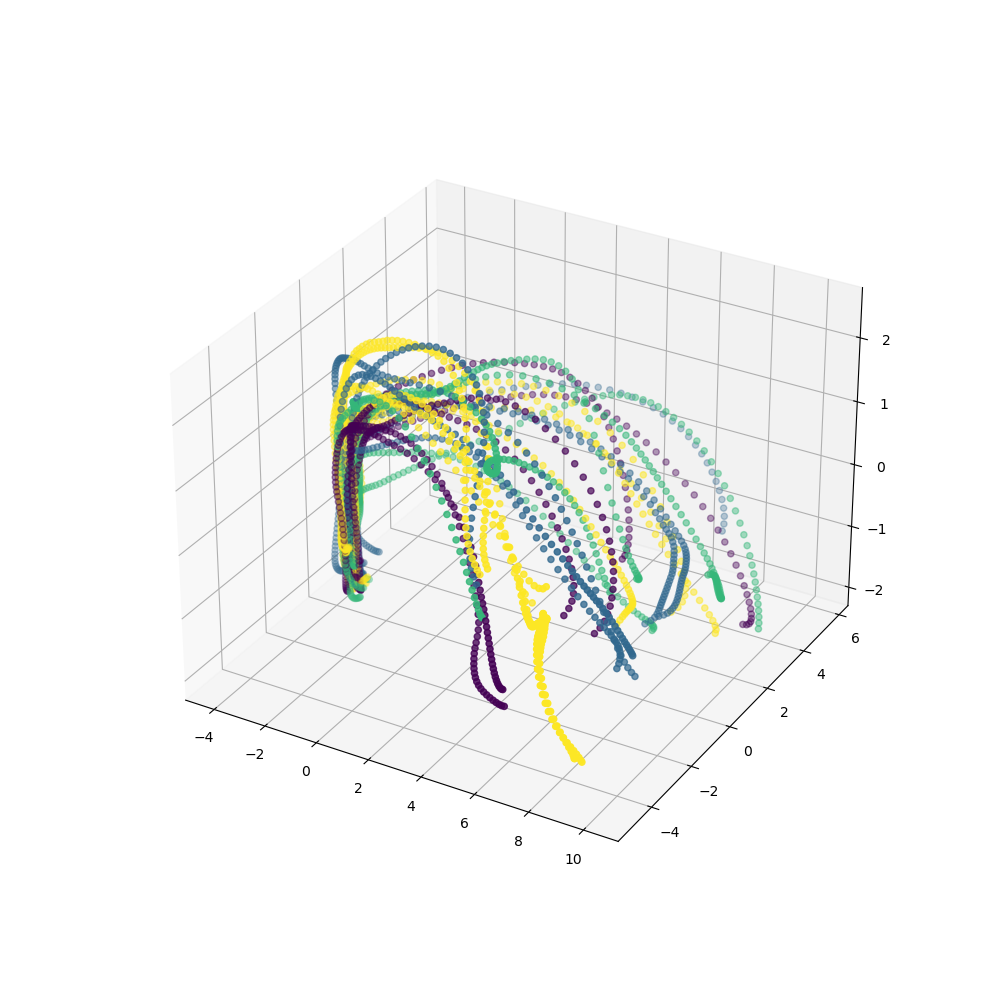

In [29]:
%matplotlib widget
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
# for trial_idx in range(4000):
#     # ax.plot(hidden_transformed[trial_idx,:,0], hidden_transformed[trial_idx,:,1], hidden_transformed[trial_idx,:,2], color=f'C{batch_labels[trial_idx]-1}')
#     # ax.scatter(hidden_transformed[trial_idx,0,0], hidden_transformed[trial_idx,0,1], hidden_transformed[trial_idx,0,2], color='k')
#     ax.scatter(hidden_transformed[trial_idx,-1,0], hidden_transformed[trial_idx,-1,1], hidden_transformed[trial_idx,-1,2], color=f'C{batch_labels[trial_idx]-1}')
ax.scatter(hidden_transformed[:,0], hidden_transformed[:,1], hidden_transformed[:,2], c=batch_labels)